## Image Analysis Techniques to Detect Triple Lines
This looks at vertical slices of grain boundary atoms and attempts to find intersection points.

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import LatticeDefinitions as ld
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSDump as LD
from scipy import stats
import os
from skimage import morphology
from scipy import spatial
from sklearn.cluster import AffinityPropagation

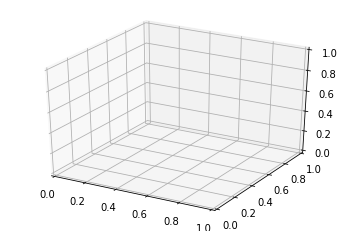

In [2]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a1 = 4.05 ##lattice parameter
a2 = a1*np.sqrt(3) #periodic cell repeat multiple
l = 3
h= 4
z = a2*np.array([0,0,h])
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
strDataFile = 'new.data'
strDumpFile = 'dump.eam'
strPMFile = strDumpFile + 'PM'
arr111BasisVectors = gf.RotatedBasisVectors(np.arccos(1/np.sqrt(3)), np.array([1,-1,0])/np.sqrt(2))
arrHorizontalVector = np.array([l*a2,0,0])
arrDiagonalVector =  np.array([a2*l/2, a2*l*np.sqrt(3)/2,0])

In [3]:
MySimulationCell = gl.SimulationCell(np.array([3*arrHorizontalVector,3*arrDiagonalVector, z])) 
objHex1 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, arr111BasisVectors, ld.FCCCell, np.array([a1,a1,a1]))
objHex2 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, gf.RotateVectors(gf.DegreesToRadians(20),z, arr111BasisVectors), ld.FCCCell, np.array([a1,a1,a1]),-arrDiagonalVector+2*arrHorizontalVector)
objHex3 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, gf.RotateVectors(gf.DegreesToRadians(40),z,arr111BasisVectors), ld.FCCCell, np.array([a1,a1,a1]), arrHorizontalVector + arrDiagonalVector)
MySimulationCell.AddGrain(objHex1)
MySimulationCell.AddGrain(objHex2)
MySimulationCell.AddGrain(objHex3)
MySimulationCell.WrapAllPointsIntoSimulationCell()
MySimulationCell.RemovePlaneOfAtoms(np.array([[0,0,1,a2*h]]),0.1)
#MySimulationCell.WriteLAMMPSDataFile(strDataFile)

In [4]:
objData = LD.LAMMPSData(strPMFile)
objTimeStep = objData.GetTimeStepByIndex(0)
objTimeStep.StandardiseOrientationData()
objPostProcess = LD.OVITOSPostProcess(np.array([objHex1.GetQuaternionOrientation(), 
                                                objHex2.GetQuaternionOrientation(), 
                                                objHex3.GetQuaternionOrientation()]), objTimeStep, 1)

In [5]:
def HalfLineDistance(inVector: np.array, inHalfLine: np.array)->np.array:
    inHalfLine = gf.NormaliseVector(inHalfLine)
    fltDot = np.dot(inVector, inHalfLine)
    fltVectorLength = np.linalg.norm(inVector, axis= 0)
    if  fltDot < 0:
        return fltVectorLength
    else:
        return np.linalg.norm(fltDot*fltVectorLength*inHalfLine - inVector, axis=0)
    

In [6]:
print(HalfLineDistance(np.array([1,2]), np.array([-1,0])),HalfLineDistance(np.array([1,2]), np.array([1,3])))


2.23606797749979 2.7543663192288093


In [7]:
def FindHalfValues(arrPoints, VectorDirection):
    arrComponents = np.matmul(arrPoints,VectorDirection)
    arrDistances = np.linalg.norm(arrPoints, axis=1)
    arrValues = np.zeros(len(arrComponents))
    lstNegatives = []
    for j in range(len(arrComponents)):
        if arrComponents[j] > 0:
            arrValues[j] = np.linalg.norm(arrComponents[j]*VectorDirection - arrPoints[j])
        else:
            arrValues[j] = arrDistances[j]
            lstNegatives.append(j)
    return arrValues, lstNegatives

In [8]:
def FindDirectionVector(arrPoints):
    matCov = np.cov(arrPoints[:,0], arrPoints[:,1])
    eValues, eVectors = np.linalg.eig(matCov)
    return gf.NormaliseVector(eVectors[:,np.argmax(eValues)])

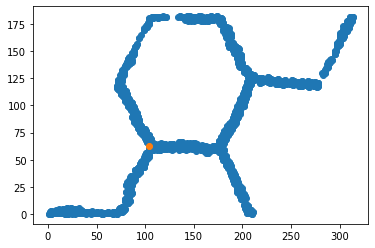

In [9]:
ptNumber = 532
pts = objPostProcess.GetGBAtoms()[:,1:4]
pts = pts[np.where(pts[:,2] < 4*a1)]
pts = pts[:,0:2]
plt.scatter(pts[:,0], pts[:,1])
plt.scatter(pts[ptNumber,0], pts[ptNumber,1])
#532 is a triple line point #200 is a triple point

In [10]:
arrRelativePoints = np.subtract(pts, pts[ptNumber])
arrDistances = np.linalg.norm(arrRelativePoints,axis=1)
arrClose = arrRelativePoints[np.where(arrDistances < 2*a2)]
InitialDirection = FindDirectionVector(arrClose)
arrHalfValues1,lst1 = FindHalfValues(arrClose, InitialDirection)
FirstDirection = FindDirectionVector(arrClose[lst1])
arrHalfValues2, lst2 = FindHalfValues(arrClose, FirstDirection)
SecondDirection = -FindDirectionVector(arrClose[lst2])
arrHalfValues3, lst3 = FindHalfValues(arrClose, SecondDirection)
lst3 = list(set(lst1) or set(lst2))
ThirdDirection = FindDirectionVector(arrClose[lst3])
arrHalfValues4, lst4 = FindHalfValues(arrClose, ThirdDirection)
print(FirstDirection, SecondDirection,ThirdDirection)

[ 0.56319631 -0.82632313] [-0.55544727  0.83155176] [ 0.56319631 -0.82632313]


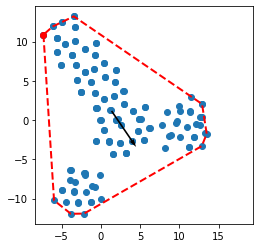

In [11]:
plt.scatter(arrClose[:,0], arrClose[:,1])
ptMean = np.mean(arrClose, axis=0)
hull = spatial.ConvexHull(arrClose)
plt.axis('square')
plt.plot(arrClose[hull.vertices,0], arrClose[hull.vertices,1], 'r--', lw=2)
plt.plot(arrClose[hull.vertices[0],0], arrClose[hull.vertices[0],1], 'ro')
plt.quiver(ptMean[0],ptMean[1],FirstDirection[0],FirstDirection[1], scale=5)
plt.show()

3
7


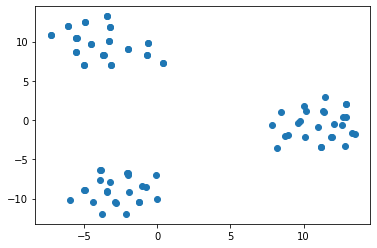

In [12]:
arrClose2 = arrClose[np.argwhere(np.linalg.norm(arrClose,axis=1) > a2)[:,0]]
plt.scatter(arrClose2[:,0],arrClose2[:,1])
af = AffinityPropagation().fit(arrClose2)
print(len(af.cluster_centers_indices_))
af2 = AffinityPropagation().fit(arrClose)
print(len(af2.cluster_centers_indices_))


In [14]:
lstAngles = []
for j in arrClose2:
    lstAngles.append(np.arctan2(j[1]/j[0]))
print(lstAngles)

ValueError: invalid number of arguments

In [ ]:
arrHalfValues1,lst1 = FindHalfValues(arrClose, FirstDirection)
#arrNegatives = np.where(arrComponents < 0) 
#arrHalfValues[arrNegatives] = arrDistances[arrNegatives]
print(arrHalfValues1)

In [ ]:
SecondDirection = gf.NormaliseVector(np.mean(arrClose[lst1], axis=0))
arrHalfValues2, lst2 = FindHalfValues(arrClose,SecondDirection)
print(arrHalfValues2)

In [ ]:
np.any(np.minimum(arrHalfValues1,arrHalfValues2) < arrHalfValues1)
lst3 = list(set(lst1) and set(lst2))
print(lst3)

In [ ]:
ThirdDirection = gf.NormaliseVector(np.mean(arrClose[lst3], axis=0))
print(FirstDirection, SecondDirection, ThirdDirection)
arrHalfValues3, lst4 = FindHalfValues(arrClose, ThirdDirection)
print(arrHalfValues3, lst4)

In [ ]:
np.sum(arrHalfValues3)